# custom dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

from opendataval.model.api import ClassifierSkLearnWrapper
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment

### [Step 1-1] Register a dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to register a dataset and define a `DataFetcher` from the registered dataset. The following codes demonstrate how to register a dataset from arrays of (random) features and (random) labels.

In [2]:
# Set up hyperparameters
dataset_name = "random_dataset"
train_count, valid_count, test_count = 50, 10, 10
noise_rate = 0.1
model_name = "sklogreg"
metric_name = "accuracy"

# Generate a random dataset
# Every element of X is generated from a standard Gaussian distribution
X, y= np.random.normal(size=(100, 10)), np.random.choice([0,1], size=100)

In [3]:
# Register a dataset from arrays X and y
pd_dataset = Register(dataset_name=dataset_name, one_hot=True).from_data(X, y)

# After regitering a dataset, we can define `DataFetcher` by its name.
fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(mix_labels, noise_rate=noise_rate)
)

### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. With `ClassifierSkLearnWrapper` and `RegressionSkLearnWrapper`, any `sklearn` models can be utilized as a prediction model. The following code uses a random forest classifier `RandomForestClassifier`. 

In [4]:
# pred_model = ClassifierSkLearnWrapper(LogisticRegression, fetcher.label_dim[0]) # example of Logistic regression
pred_model = ClassifierSkLearnWrapper(RandomForestClassifier, fetcher.label_dim[0])

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [5]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [6]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(), # LAVA
    RobustVolumeShapley(gr_threshold=1.05) # VolumeShapley
]

In [7]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.001707


100%|██████████| 50/50 [00:01<00:00, 32.42it/s]


Elapsed time LeaveOneOut(): 0:00:01.610764


100%|██████████| 1000/1000 [00:30<00:00, 33.00it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:00:30.303088


100%|██████████| 2000/2000 [01:00<00:00, 33.06it/s]


Elapsed time DVRL(rl_epochs=2000): 0:01:00.594737


100%|██████████| 49/49 [00:00<00:00, 29893.95it/s]

Elapsed time KNNShapley(k_neighbors=10): 0:00:00.003361
Start: marginal contribution computation



100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


gr_stat=100


100%|██████████| 100/100 [01:33<00:00,  1.06it/s]


gr_stat=100


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


gr_stat=100


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


gr_stat=100


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]

gr_stat=1.0161827805569674
Total number of trained models to estimate marginal
               contributions: 15018
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, cache_name=cached): 0:07:36.659804
Elapsed time BetaShapley(gr_threshold=1.05, cache_name=cached): 0:00:00.000185


100%|██████████| 1000/1000 [00:29<00:00, 33.64it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:29.730192


100%|██████████| 1000/1000 [00:30<00:00, 33.04it/s]


Elapsed time AME(num_models=1000): 0:01:58.821159


100%|██████████| 1000/1000 [00:30<00:00, 32.89it/s]


Elapsed time DataOob(num_models=1000): 0:00:30.403590


Elapsed time LavaEvaluator(): 0:00:00.022971
Start: marginal contribution computation


100%|██████████| 100/100 [00:01<00:00, 55.62it/s]


gr_stat=100


100%|██████████| 100/100 [00:01<00:00, 55.39it/s]


gr_stat=100


100%|██████████| 100/100 [00:01<00:00, 55.45it/s]


gr_stat=100


100%|██████████| 100/100 [00:01<00:00, 55.45it/s]


gr_stat=100


100%|██████████| 100/100 [00:01<00:00, 55.42it/s]

gr_stat=1.0159839128614154
Total number of trained models to estimate marginal
               contributions: 22500
Done: marginal contribution computation
Elapsed time RobustVolumeShapley(gr_threshold=1.05): 0:00:09.020950
CPU times: user 12min 9s, sys: 8.02 s, total: 12min 17s
Wall time: 12min 17s


## [Step 3] Evaluate data values

In [8]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/random_dataset_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [9]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.114286
"BetaShapley(gr_threshold=1.05, cache_name=cached)",0.117647
DVRL(rl_epochs=2000),0.055556
DataBanzhaf(num_models=1000),0.102564
DataOob(num_models=1000),0.086957
"DataShapley(gr_threshold=1.05, cache_name=cached)",0.153846
InfluenceSubsample(num_models=1000),0.125000
KNNShapley(k_neighbors=10),0.206897
LavaEvaluator(),0.100000
LeaveOneOut(),0.176471


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

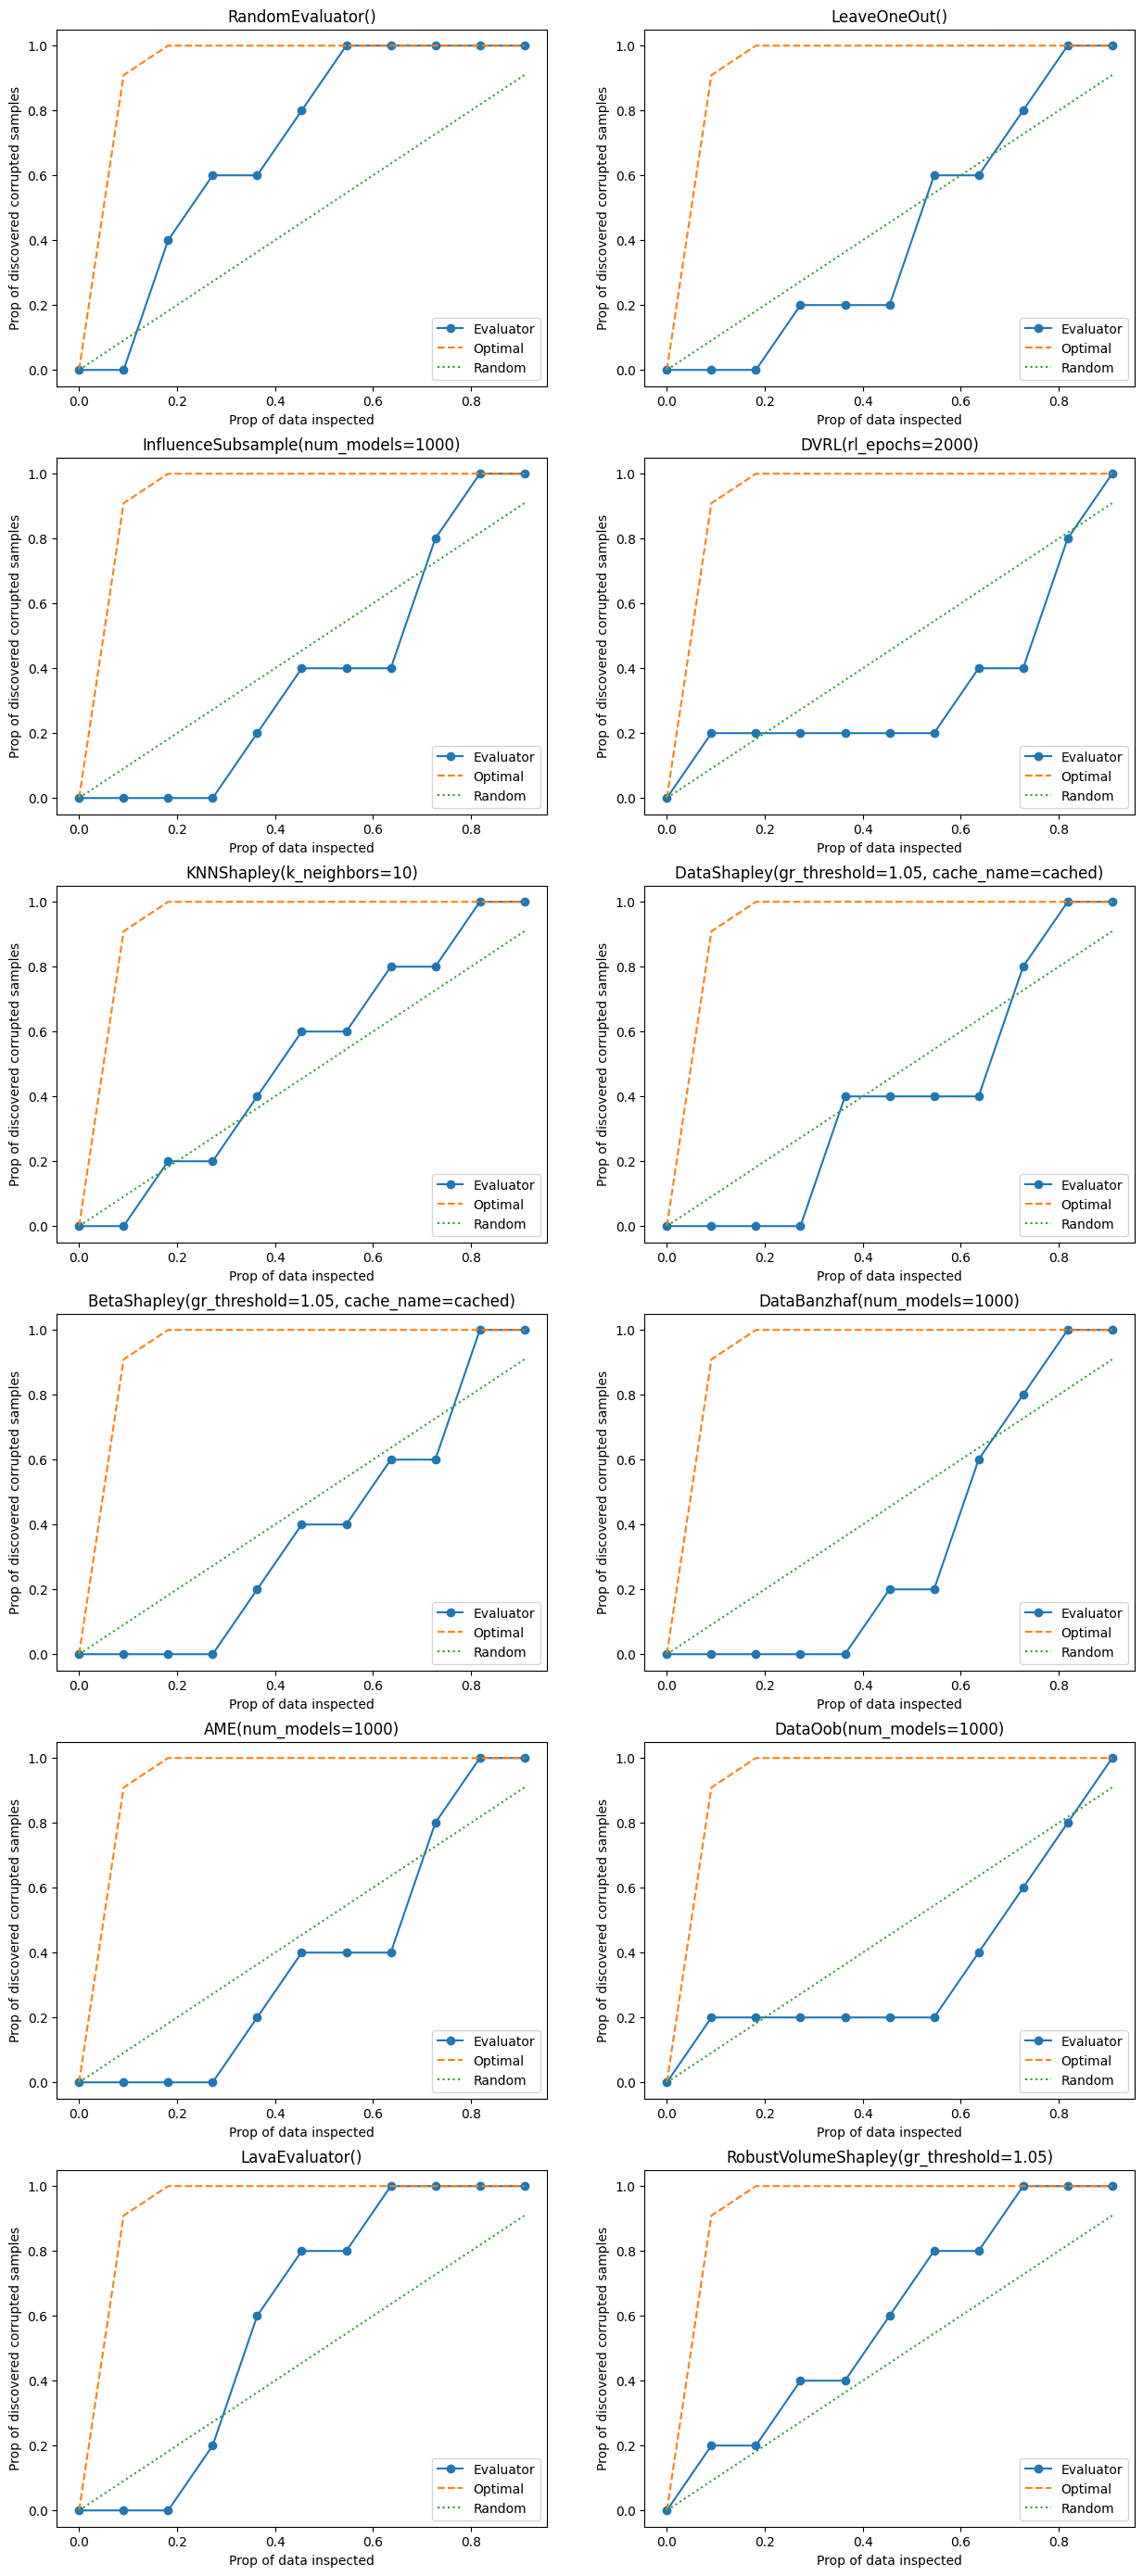

In [16]:
fig = plt.figure(figsize=(15, 35))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

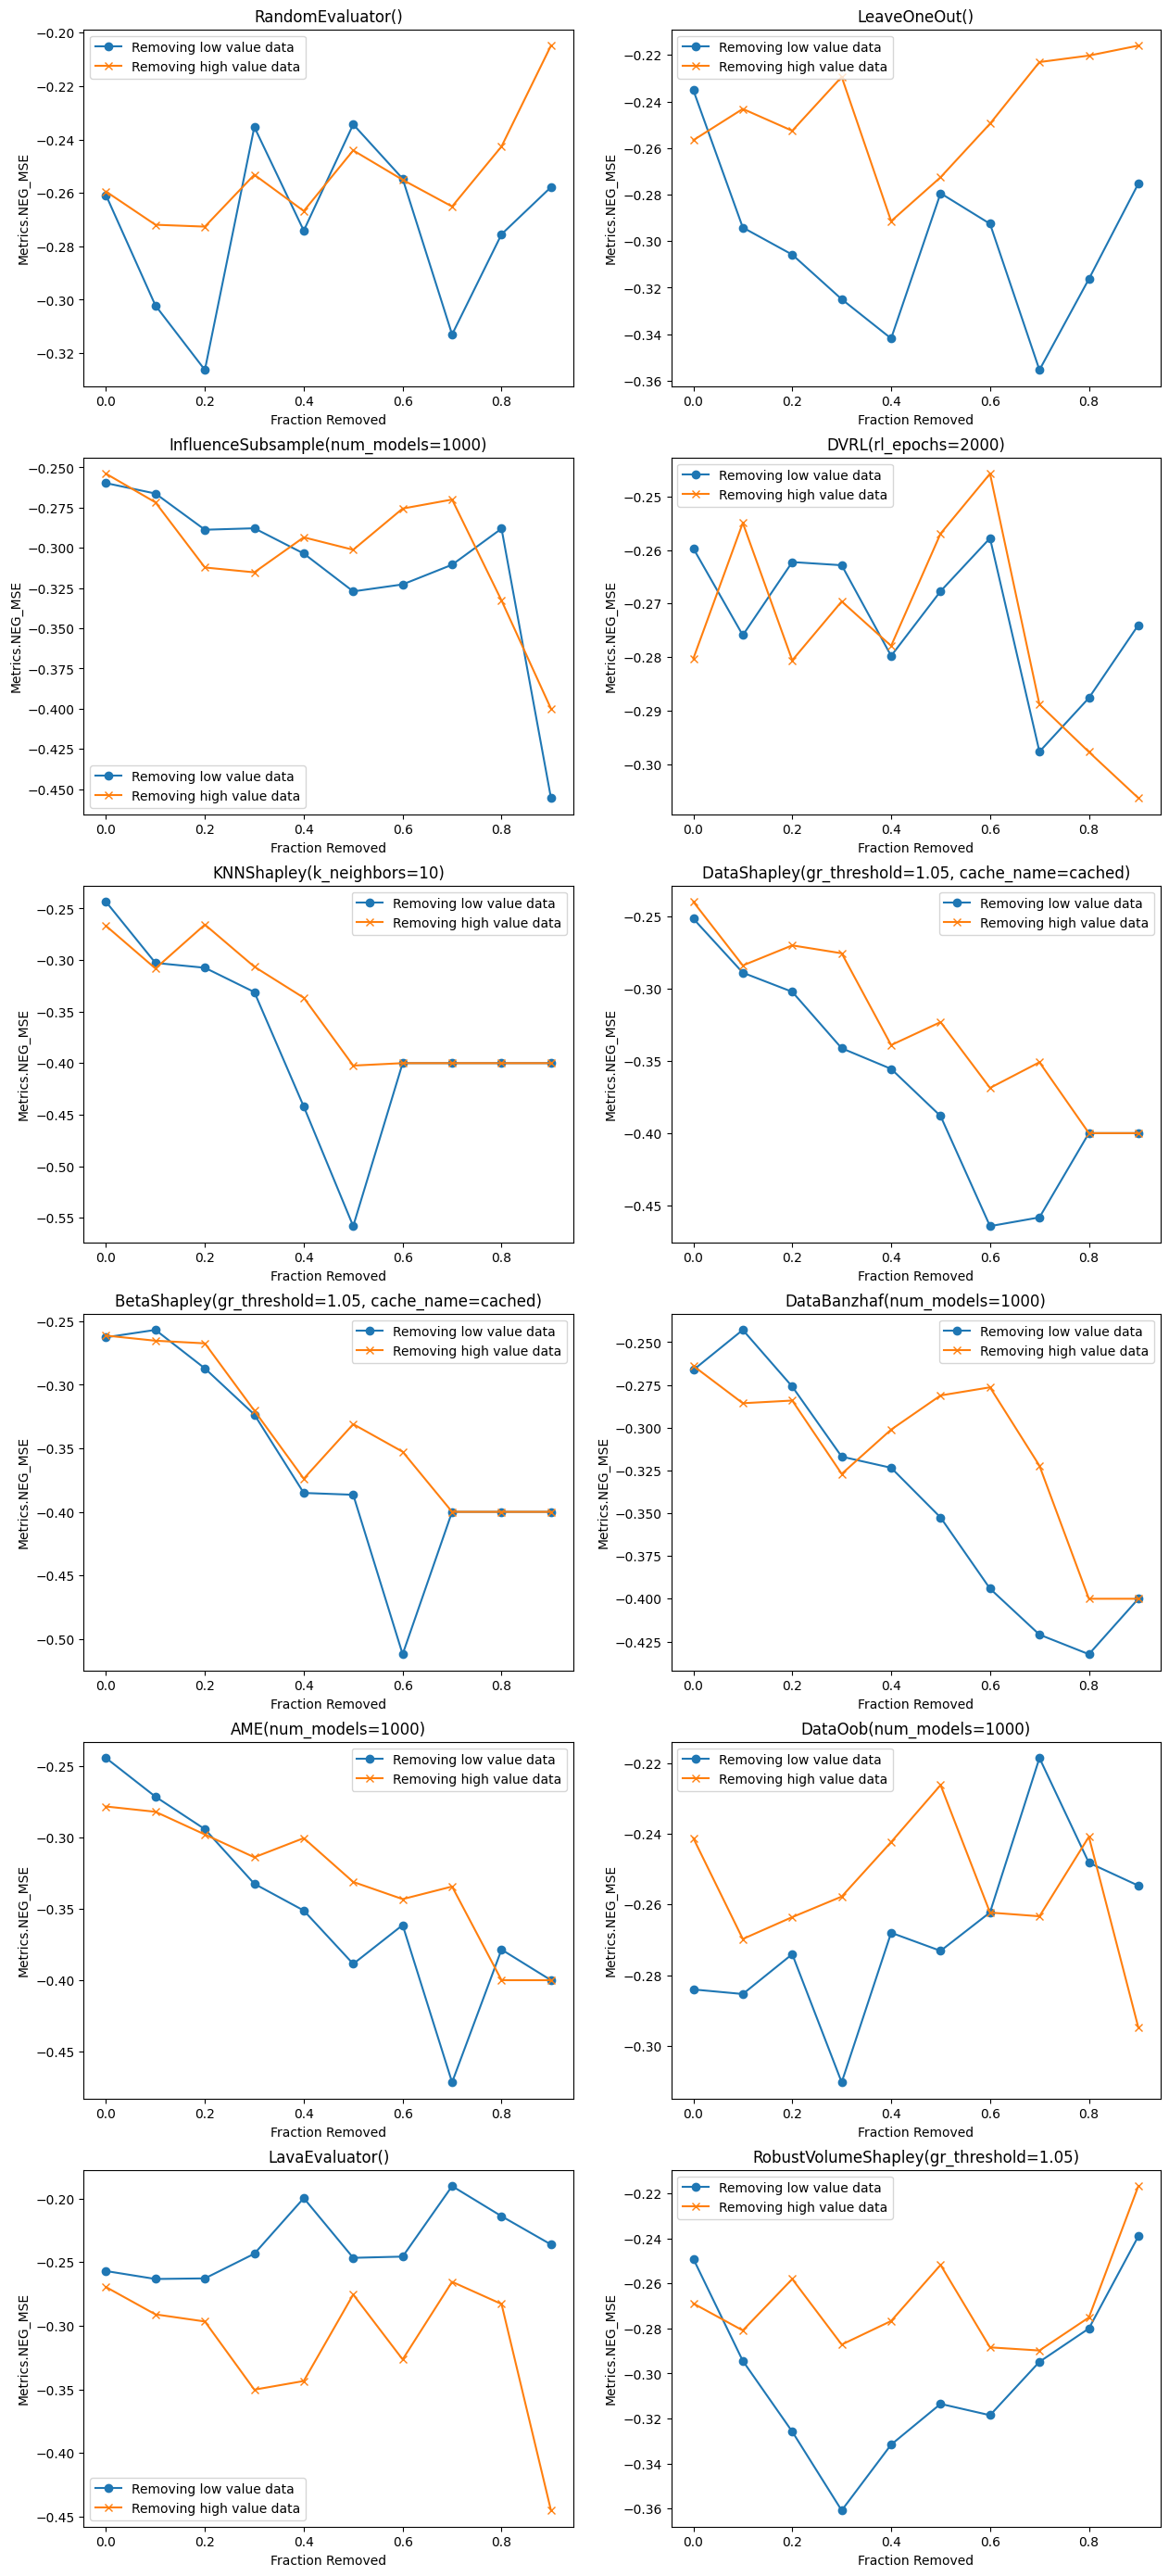

In [17]:
fig = plt.figure(figsize=(15, 35))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [12]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.2546,-0.23461,0.0
RandomEvaluator(),-0.30187,-0.25084,0.1
RandomEvaluator(),-0.2954,-0.26292,0.2
RandomEvaluator(),-0.25635,-0.24516,0.3
RandomEvaluator(),-0.26044,-0.28426,0.4
...,...,...,...
RobustVolumeShapley(gr_threshold=1.05),-0.3216,-0.27856,0.5
RobustVolumeShapley(gr_threshold=1.05),-0.28315,-0.26757,0.6
RobustVolumeShapley(gr_threshold=1.05),-0.27301,-0.30247,0.7
RobustVolumeShapley(gr_threshold=1.05),-0.2998,-0.27104,0.8


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [13]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),1,0.393476
RandomEvaluator(),79,0.378603
RandomEvaluator(),2,0.833422
RandomEvaluator(),93,0.106839
RandomEvaluator(),40,0.602039
...,...,...
RobustVolumeShapley(gr_threshold=1.05),99,7583688.685236
RobustVolumeShapley(gr_threshold=1.05),10,10993625.28668
RobustVolumeShapley(gr_threshold=1.05),6,4778217.029037
RobustVolumeShapley(gr_threshold=1.05),15,5842151.324937
